In [6]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import os
import json
import csv

In [7]:
video_order = ["36Kb", "540Kb", "1Mb", "6Mb"]

color_mapping = {
    "moviepy": "#17becf",
    "ffmpeg": "#ff7f0e",
    "imageio": "#f0e68c",
    "opencv": "#27ae60"
}

bar_width = 0.18

def max_abs_scale(series):
    return series / series.abs().max()

In [8]:
headers = ['duration_seconds', 'cpu0_package_joules', 'cpu0_dram_joules', 'cpu1_package_joules', 'cpu1_dram_joules', 'video', 'library']
data = []

for dir in os.listdir("result/energy"):
    # For each subfolder in Energy folder (1Mb.JPEG)
        dir_path = os.path.join("result/energy", dir)
        video = dir.replace(".avi", "")

        for file in os.listdir(dir_path):
            # For each file in the subfolder (pillow1Mb.JPEG.txt)
            file_paht = os.path.join(dir_path, file)
            library = file.replace(video+".avi.txt", "")

            with open(file_paht, 'r') as file:
                lines = file.readlines()
            
            for line in lines:
                line = line.strip()
                if line.startswith('duration_seconds'):
                    duration_seconds = line.split('=')[1]
                elif line.startswith('cpu0_package_joules'):
                    cpu0_package_joules = line.split('=')[1]
                elif line.startswith('cpu0_dram_joules'):
                    cpu0_dram_joules = line.split('=')[1]
                elif line.startswith('cpu1_package_joules'):
                    cpu1_package_joules = line.split('=')[1]
                elif line.startswith('cpu1_dram_joules'):
                    cpu1_dram_joules = line.split('=')[1]

                    # Append the extracted values to the data list
                    data.append([duration_seconds, 
                                cpu0_package_joules, 
                                cpu0_dram_joules, 
                                cpu1_package_joules, 
                                cpu1_dram_joules, 
                                video, 
                                library])

with open("result/energy.csv", 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Write the header
        writer.writerows(data)    # Write the data

In [9]:
df = pd.read_csv("result/energy.csv")
df["energy"] = df["cpu0_package_joules"] + df["cpu1_package_joules"]
# df.head()

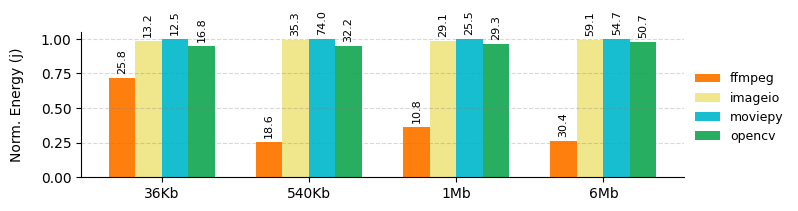

In [ ]:
dftt = df.copy()
mean_df = dftt.groupby(['library', 'video'], as_index=False)['energy'].mean()
mean_df.rename(columns={'energy': 'mean_energys'}, inplace=True)
std_df = dftt.groupby(['library', 'video'], as_index=False)['energy'].std()
std_df.rename(columns={'energy': 'std_energy'}, inplace=True)

dftt = std_df.merge(mean_df, on=['library', 'video'])
dfe_max_abs = dftt.copy()
dfe_max_abs['mean_energys'] = dfe_max_abs.groupby('video')['mean_energys'].transform(max_abs_scale)
dfe_max_abs['video'] = pd.Categorical(dfe_max_abs['video'], categories=video_order, ordered=True)
dfe_max_abs = dfe_max_abs.sort_values(['library', 'video'])

# Define the libraries and image sizes
libraries = dfe_max_abs['library'].unique()
image_sizes = dfe_max_abs['video'].unique()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 2.2))

# Set the positions of the bars on the x-axis
positions = np.arange(len(image_sizes))

# Plot each image size
for i, library in enumerate(libraries):
    subset = dfe_max_abs[dfe_max_abs['library'] == library]
    bar_positions = positions + i * bar_width
    bars = ax.bar(bar_positions, subset['mean_energys'], width=bar_width, label=library, color=color_mapping[library])

    for bar, std in zip(bars, subset['std_energy']):
        height = bar.get_height()
        ax.annotate(f'{std:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8, rotation=90)

# Set the labels and title
ax.set_ylabel('Norm. Energy (j)', fontsize=10, labelpad=12) 
ax.spines[['right', 'top']].set_visible(False)

ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)

# Set the x-ticks and labels
ax.set_xticks(positions + bar_width * (len(libraries) - 1) / 2)
ax.set_xticklabels(image_sizes)

ax.legend(
    bbox_to_anchor=(1, 0.8), loc='upper left', ncols = 1, frameon=False, fontsize=9
)
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Times

In [11]:
def parse_json_objects(log_content):
    json_objects = []
    buffer = ""
    brace_count = 0
    for char in log_content:
        buffer += char
        if char == '{':
            brace_count += 1
        elif char == '}':
            brace_count -= 1
        
        if brace_count == 0 and buffer.strip():
            try:
                json_objects.append(json.loads(buffer.strip()))
                buffer = ""
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                buffer = ""

    return json_objects

with open('result/result.txt', 'r') as file:
    log_content = file.read()

json_objects = parse_json_objects(log_content)

headers = ["compute_time", "download_size", "download_time", "video", "library", "upload_size", "upload_time"]

with open('result/result.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=headers)
    writer.writeheader()

    for data in json_objects:
        try:
            writer.writerow({
                "compute_time": data["compute_time"],
                "download_size": data["download_size"],
                "download_time": data["download_time"],
                "video": data["video"].replace(".avi", ""),
                "library": data["library"],
                "upload_size": data["upload_size"],
                "upload_time": data["upload_time"]
            })
        except KeyError as e:
            print(f"Missing key in data: {e}")

print("CSV file has been created successfully.")


CSV file has been created successfully.


In [12]:
df = pd.read_csv("result/result.csv")
df["total_time"] = df["compute_time"] + df["upload_time"] + df["download_time"]
# df.head()

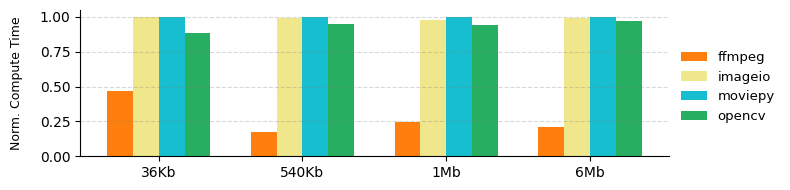

In [ ]:
dfct = df.copy()

dfct = dfct.groupby(['library', 'video'], as_index = False)['compute_time'].mean()
dfct['normalized_compute_time'] = dfct.groupby('video')['compute_time'].transform(max_abs_scale)
dfct['video'] = pd.Categorical(dfct['video'], categories=video_order, ordered=True)
dfct = dfct.sort_values(['library', 'video'])

# Define the libraries and video sizes
libraries = dfct['library'].unique()
video_sizes = dfct['video'].unique()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 2))

# Set the positions of the bars on the x-axis
positions = np.arange(len(video_sizes))

# Plot each video size
for i, library in enumerate(libraries):
    subset = dfct[dfct['library'] == library]
    bar_positions = positions + i * bar_width
    ax.bar(bar_positions, subset['normalized_compute_time'], width=bar_width, label=library, color=color_mapping[library])

# Set the labels and title
ax.set_ylabel('Norm. Compute Time', fontsize=9, labelpad=12)

ax.spines[['right', 'top']].set_visible(False)

ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)

# Set the x-ticks and labels
ax.set_xticks(positions + bar_width * (len(libraries) - 1) / 2)
ax.set_xticklabels(video_sizes)
ax.legend(
    bbox_to_anchor=(1, 0.8), loc='upper left', ncols = 1, frameon=False, fontsize=9.5
)

# plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

**Observation 1 : ffmpeg a les temps de traitement les plus bas.**

Le diagramme ComputeTime.png  présente les temps moyens nécessaires pour transformer une vidéo en GIF pour chaque bibliothèque. On constate que ffmpeg a le temps de traitement le plus bas peu importe la taille de la vidéo en entrée. L'écart entre les autres bibliothèques n'est pas très grand, mais OpenCV est tout de même  assez plus rapide que imageio et moviepy.

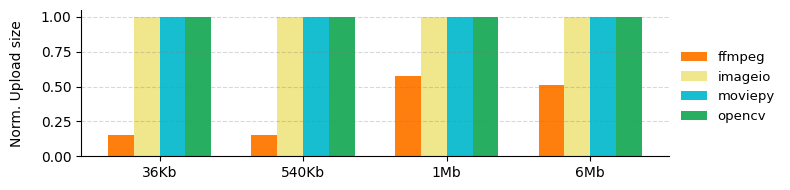

In [ ]:
dfus = df.copy()

dfus = dfus.groupby(['library', 'video'], as_index = False)['upload_size'].mean()
dfus['normalized_upload_size'] = dfus.groupby('video')['upload_size'].transform(max_abs_scale)
dfus['video'] = pd.Categorical(dfus['video'], categories=video_order, ordered=True)
dfus = dfus.sort_values(['library', 'video'])

libraries = dfus['library'].unique()
video_sizes = dfus['video'].unique()

fig, ax = plt.subplots(figsize=(8, 2))

# Plot each video size
for i, library in enumerate(libraries):
    subset = dfus[dfus['library'] == library]
    bar_positions = positions + i * bar_width
    ax.bar(bar_positions, subset['normalized_upload_size'], width=bar_width, label=library, color=color_mapping[library])

ax.set_ylabel('Norm. Upload size', fontsize=10, labelpad=12)
ax.spines[['right', 'top']].set_visible(False)

ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)
ax.set_xticks(positions + bar_width * (len(libraries) - 1) / 2)
ax.set_xticklabels(video_sizes)

ax.legend(
    bbox_to_anchor=(1, 0.8), loc='upper left', ncols = 1, frameon=False, fontsize=9.5
)

plt.tight_layout()
plt.show()


**Observation 4 : ffmpeg produit une image GIF de moins bonne qualité**

L 'histogramme FinalSize.png permet de comparer la qualité de l'image GIF finale produite par chaque bibliothèque en se basant sur la taille du fichier final. On constate que ffmpeg produit une image GIF de moins bonne qualité que les autres bibliothèques. Excepté ffmpeg les autres bibliothèques produisent en sortie une image GIF de même tailles et donc de qualité égale.

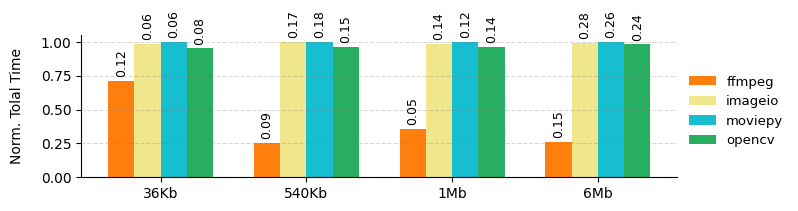

In [ ]:
dftt = df.copy()
mean_df = dftt.groupby(['library', 'video'], as_index=False)['total_time'].mean()
mean_df.rename(columns={'total_time': 'mean_total_time'}, inplace=True)
std_df = dftt.groupby(['library', 'video'], as_index=False)['total_time'].std()
std_df.rename(columns={'total_time': 'std_total_time'}, inplace=True)

dftt = std_df.merge(mean_df, on=['library', 'video'])
dftt['normalized_total_time'] = dftt.groupby('video')['mean_total_time'].transform(max_abs_scale)
dftt['video'] = pd.Categorical(dftt['video'], categories=video_order, ordered=True)
dftt = dftt.sort_values(['library', 'video'])

libraries = dftt['library'].unique()
video_sizes = dftt['video'].unique()

fig, ax = plt.subplots(figsize=(8, 2.2))

positions = np.arange(len(video_sizes))

for i, library in enumerate(libraries):
    subset = dftt[dftt['library'] == library]
    bar_positions = positions + i * bar_width
    bars = ax.bar(bar_positions, subset['normalized_total_time'], width=bar_width, label=library, color=color_mapping[library])

    for bar, std in zip(bars, subset['std_total_time']):
        height = bar.get_height()
        ax.annotate(f'{std:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9, rotation=90)

ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)

ax.set_ylabel('Norm. Tolal Time', fontsize=10, labelpad=12)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks(positions + bar_width * (len(libraries) - 1) / 2)
ax.set_xticklabels(video_sizes)
ax.legend(
    bbox_to_anchor=(1, 0.8), loc='upper left', ncols = 1, frameon=False, fontsize=9.5
)

plt.tight_layout()
plt.show()

**Observation 2: ffmpeg a le coût en temps total le plus bas peu importe la taille de la vidéo en entrée**

L 'histogramme TotalTime.png présente les coûts moyens total en temps  pour l’exécution du benchmark, incluant le temps de transformation de la vidéo en GIF, de téléchargement, et retour du résultat. On constate principalement que ffmpeg conserve un coût total en temps plus bas peu importe la vidéo en entrée.


**Interprétation coté utilisateur** : Sous la base des informations précédente, du point de vue utilisateur, la meilleure alternative pour ce benchmark serait d'utliser OpenCV car il produit un résultat de meilleur qualité, avec des couts en temps globalement plus proches de ffmpeg.

**Interprétation coté fournisseur** : La meilleure alternative serait d'utiliser ffmpeg car il a des couts en temps les plus bas, ainsi que la consommation énergétique la plus basse.
